# Introduction to CNNs...
### ...And ways to improve accuracy on the Kaggle Competition

In [ ]:
!nvidia-smi

### Tip

Use DataHub!!

https://datahub.ucsd.edu

If you are facing issues when `git clone`ing, follow these steps to add an SSH Key to Datahub: https://docs.github.com/en/authentication/connecting-to-github-with-ssh/adding-a-new-ssh-key-to-your-github-account

## CNNs, and how to train 'em

In [ ]:
# code inspiration from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128

# get the dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# create dataloaders for minibatch generation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

100%|██████████| 170498071/170498071 [00:13<00:00, 12812601.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # filter weight shape: (3, 10, 5, 5)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5)

        self.pool = nn.MaxPool2d(2, 2)

        # filter weight shape: (10, 20, 5, 5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)

        self.fc1 = nn.Linear(20 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def get_loss_and_accuracy(images, labels, net, criterion):
    logits = net(images)
    loss = criterion(logits, labels)
    pred = logits.argmax(dim=1, keepdim=True)
    correct = pred.eq(labels.view_as(pred)).sum().item()
    return loss, correct

In [ ]:
def test(dataloader, net, criterion):
    test_loss, test_accuracy = 0.0, 0.0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            loss, accuracy = get_loss_and_accuracy(images, labels, net, criterion)
            test_loss += loss
            test_accuracy += accuracy
    
    return test_loss.cpu().detach().numpy() / len(dataloader), test_accuracy * 100 / len(dataloader.dataset)

In [ ]:
from tqdm import tqdm

losses = []
accuracies = []

# train the model for X epochs
for epoch in tqdm(range(100)):
    running_loss = 0.0
    running_accuracy = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss, accuracy = get_loss_and_accuracy(images, labels, net, criterion)

        loss.backward()
        optimizer.step()

        running_loss += loss.cpu().detach().numpy()
        running_accuracy += accuracy
    
    losses.append(running_loss / len(trainloader))
    accuracies.append(running_accuracy * 100 / len(trainloader.dataset))

print('Finished Training')

print('Testing')
test_loss, test_accuracy = test(testloader, net, criterion)
print(f'\n\ntest loss: {test_loss}\ntest accuracy: {test_accuracy} %')

100%|██████████| 100/100 [23:08<00:00, 13.88s/it]

Finished Training
Testing




test loss: 1.066390508337866
test accuracy: 68.37 %


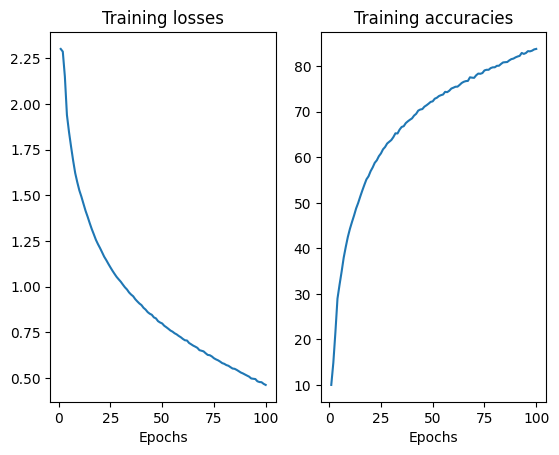

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
e = len(losses)
x_axis = np.arange(1, e + 1, 1)
plt.subplot(121)
plt.plot(x_axis, losses)
plt.title('Training losses')
plt.xlabel("Epochs")
plt.subplot(122)
plt.plot(x_axis, accuracies)
plt.title('Training accuracies')
plt.xlabel("Epochs")
plt.show()

## I reach an accuracy of $X$ on CIFAR \*cough Kaggle\* -10 \*cough Competition*, but how do I reach $X + 1$?

Table of contents:

*   Using a Validation Set
*   Hyperparameter Tuning
*   Early Stopping
*   Data Augmentation
*   Learning Rate Scheduler
*   Dropout
*   Normalization
*   Transfer Learning



### Using a Validation Set

In [ ]:
from torch.utils.data import random_split

def train_val_split(train_dataset):
    train_size = int(len(train_dataset) * 0.8)
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size],
                                            generator=torch.Generator().manual_seed(42))
    return train_subset, val_subset

train_subset, val_subset = train_val_split(trainset)

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
from tqdm import tqdm

def train(net, trainloader, valloader, criterion, optimizer, epochs):
    losses = []
    val_losses = []
    accuracies = []
    val_accuracies = []

    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        running_accuracy = 0.0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            loss, accuracy = get_loss_and_accuracy(images, labels, net, criterion)

            loss.backward()
            optimizer.step()

            running_loss += loss.cpu().detach().numpy()
            running_accuracy += accuracy
        
        val_loss, val_accuracy = test(valloader, net, criterion)

        losses.append(running_loss / len(trainloader))
        accuracies.append(running_accuracy * 100 / len(trainloader.dataset))
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    return net, losses, accuracies, val_losses, val_accuracies

In [ ]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
net, losses, accuracies, val_losses, val_accuracies = train(net, trainloader, valloader, criterion, optimizer, 100)

100%|██████████| 100/100 [22:40<00:00, 13.61s/it]


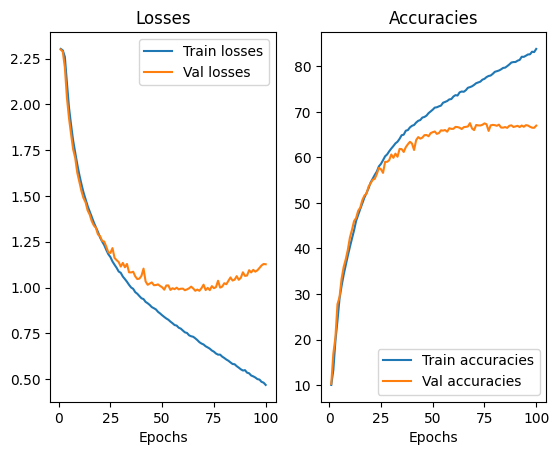

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot(train_losses, train_accs, val_losses, val_accs):
    plt.figure()
    e = len(val_losses)
    x_axis = np.arange(1, e + 1, 1)
    plt.subplot(121)
    plt.plot(x_axis, train_losses, label='Train losses')
    plt.plot(x_axis, val_losses, label='Val losses')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    plt.subplot(122)
    plt.plot(x_axis, train_accs, label='Train accuracies')
    plt.plot(x_axis, val_accs, label='Val accuracies')
    plt.title('Accuracies')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    plt.show()

plot(losses, accuracies, val_losses, val_accuracies)

### Hyperparameter Tuning

100%|██████████| 100/100 [22:44<00:00, 13.65s/it]


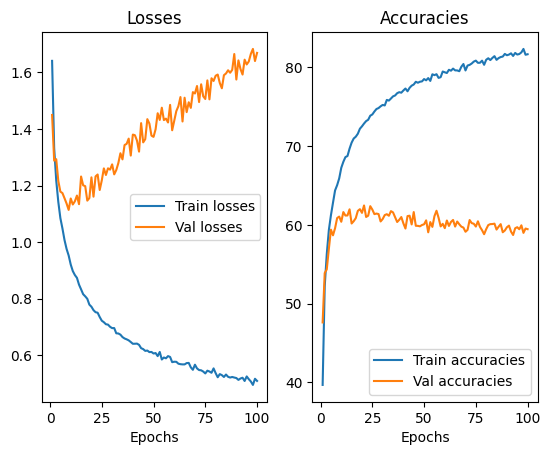

In [ ]:
# Adam LR = 0.005, weight decay = 0.0001
net = Net().to(device)
optimizer1 = optim.Adam(net.parameters(), lr=0.005, weight_decay=0.0001)
best_model1, losses1, accuracies1, val_losses1, val_accuracies1 = train(net, trainloader, valloader, criterion, optimizer1, 100)
plot(losses1, accuracies1, val_losses1, val_accuracies1)

100%|██████████| 100/100 [22:37<00:00, 13.57s/it]


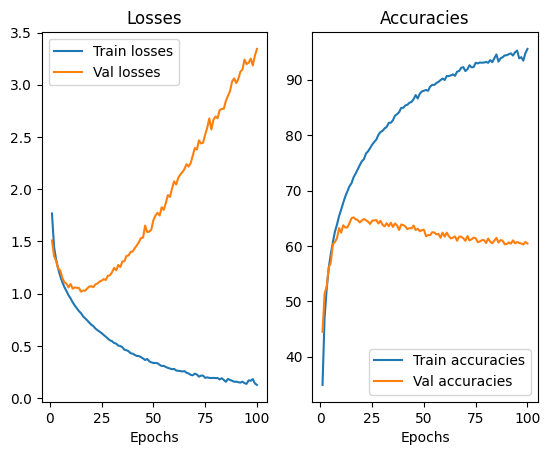

In [ ]:
# Adam LR = 0.001, weight decay = 0.0001
net = Net().to(device)
optimizer2 = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
best_model2, losses2, accuracies2, val_losses2, val_accuracies2 = train(net, trainloader, valloader, criterion, optimizer2, 100)
plot(losses2, accuracies2, val_losses2, val_accuracies2)

### Early Stopping

In [ ]:
import math
from copy import deepcopy

def train(net, trainloader, valloader, criterion, optimizer, epochs):
    best_model = deepcopy(net.state_dict())
    losses = []
    val_losses = []
    accuracies = []
    val_accuracies = []
    min_loss = math.inf
    patience = 0

    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        running_accuracy = 0.0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            loss, accuracy = get_loss_and_accuracy(images, labels, net, criterion)

            loss.backward()
            optimizer.step()

            running_loss += loss.cpu().detach().numpy()
            running_accuracy += accuracy
        
        val_loss, val_accuracy = test(valloader, net, criterion)

        if val_loss < min_loss:
                min_loss = val_loss
                best_model = deepcopy(net.state_dict())

        # early stop if model starts overfitting
        if epoch > 0 and val_loss > val_losses[epoch - 1]:
            patience += 1
        if patience >= 10:
            print('\nEarly stopping!')
            break

        losses.append(running_loss / len(trainloader))
        accuracies.append(running_accuracy * 100 / len(trainloader.dataset))
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    return best_model, losses, accuracies, val_losses, val_accuracies

 32%|███▏      | 32/100 [07:36<16:09, 14.26s/it]


Early stopping!


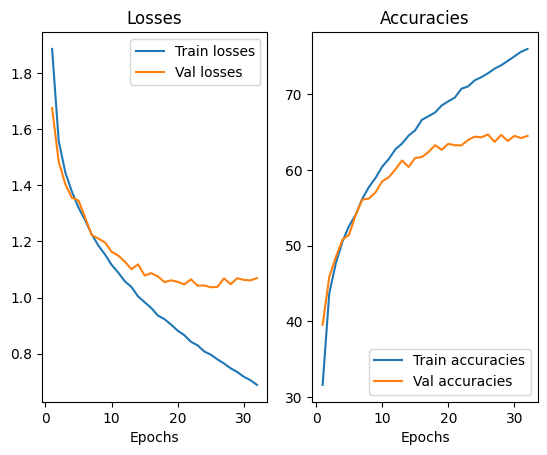

In [ ]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0005, weight_decay=0.0001)
best_model, losses, accuracies, val_losses, val_accuracies = train(net, trainloader, valloader, criterion, optimizer, 100)
plot(losses, accuracies, val_losses, val_accuracies)

### Learning Rate Scheduler

In [ ]:
import math
from copy import deepcopy
from tqdm import tqdm

def train(net, trainloader, valloader, criterion, optimizer, lr_scheduler, epochs):
    best_model = deepcopy(net.state_dict())
    losses = []
    val_losses = []
    accuracies = []
    val_accuracies = []
    min_loss = math.inf
    patience = 0

    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        running_accuracy = 0.0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            loss, accuracy = get_loss_and_accuracy(images, labels, net, criterion)

            loss.backward()
            optimizer.step()

            running_loss += loss.cpu().detach().numpy()
            running_accuracy += accuracy
        
        val_loss, val_accuracy = test(valloader, net, criterion)

        if val_loss < min_loss:
                min_loss = val_loss
                best_model = deepcopy(net.state_dict())

        # early stop if model starts overfitting
        if epoch > 0 and val_loss > val_losses[epoch - 1]:
            patience += 1
        else:
            patience = 0
        if patience >= 10:
            print('\nEarly stopping!')
            break

        losses.append(running_loss / len(trainloader))
        accuracies.append(running_accuracy * 100 / len(trainloader.dataset))
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        lr_scheduler.step()

    return best_model, losses, accuracies, val_losses, val_accuracies

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot(train_losses, train_accs, val_losses, val_accs):
    plt.figure()
    e = len(val_losses)
    x_axis = np.arange(1, e + 1, 1)
    plt.subplot(121)
    plt.plot(x_axis, train_losses, label='Train losses')
    plt.plot(x_axis, val_losses, label='Val losses')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    plt.subplot(122)
    plt.plot(x_axis, train_accs, label='Train accuracies')
    plt.plot(x_axis, val_accs, label='Val accuracies')
    plt.title('Accuracies')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    plt.show()

 52%|█████▏    | 52/100 [12:27<11:30, 14.38s/it]


Early stopping!


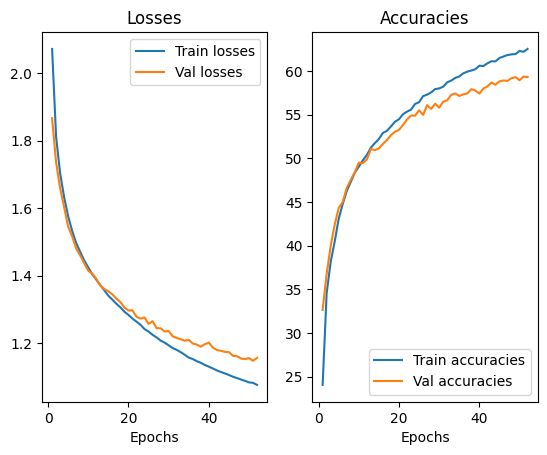

In [ ]:
# without reinitializing patience to 0 if current loss is less than previous loss
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.00001)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=100)
best_model, losses, accuracies, val_losses, val_accuracies = train(net, trainloader, valloader, criterion, optimizer, lr_scheduler, 100)
plot(losses, accuracies, val_losses, val_accuracies)

 61%|██████    | 61/100 [14:27<09:14, 14.22s/it]


Early stopping!


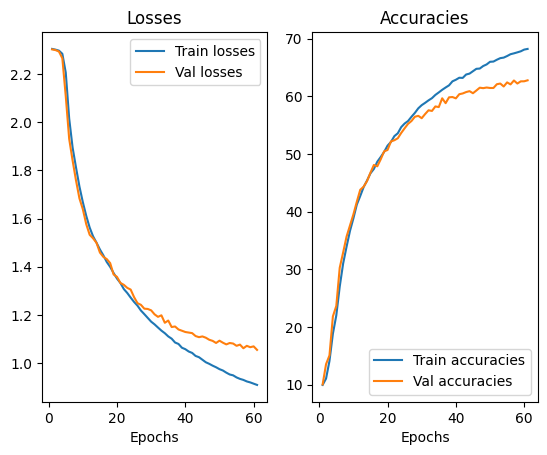

In [ ]:
# without reinitializing patience to 0 if current loss is less than previous loss
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=100)
best_model, losses, accuracies, val_losses, val_accuracies = train(net, trainloader, valloader, criterion, optimizer, lr_scheduler, 100)
plot(losses, accuracies, val_losses, val_accuracies)

100%|██████████| 100/100 [22:16<00:00, 13.36s/it]


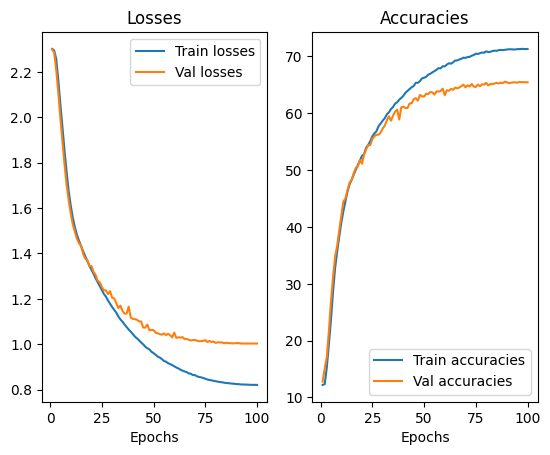

In [ ]:
# reinitializing patience to 0 if current loss is less than previous loss
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=100)
best_model, losses, accuracies, val_losses, val_accuracies = train(net, trainloader, valloader, criterion, optimizer, lr_scheduler, 100)
plot(losses, accuracies, val_losses, val_accuracies)

### Data Augmentation

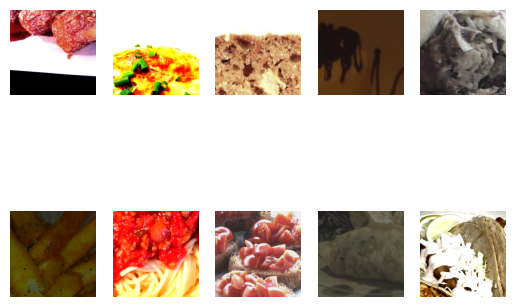

In [ ]:
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.RandomCrop((200, 200)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.8, contrast=0.6, saturation=0.7),
    transforms.ToTensor()
])
batch_size = 10
trainset = torchvision.datasets.Food101(root='./data', split='test', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

fig = plt.figure()
for i, (image, _) in enumerate(trainloader):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image[5].permute(1, 2, 0))
    plt.axis('off')
    if i == 9:
        break
plt.show()

### Dropout


> When a large feedforward neural network is trained on a small training set, it typically performs poorly on held-out test data. This "overfitting" is greatly reduced by randomly omitting half of the feature detectors on each training case. This prevents complex co-adaptations in which a feature detector is only helpful in the context of several other specific feature detectors. Instead, each neuron learns to detect a feature that is generally helpful for producing the correct answer given the combinatorially large variety of internal contexts in which it must operate.

https://arxiv.org/abs/1207.0580



In [ ]:
m = torch.nn.Dropout(p=0.5)
input = torch.randn(1, 8)
output = m(input)
print(input)
print(output)

tensor([[ 0.6053, -1.4687,  0.2471, -1.3078,  0.3010,  2.2961,  0.2403,  0.9121]])
tensor([[ 0.0000, -2.9374,  0.0000, -2.6157,  0.6019,  0.0000,  0.0000,  0.0000]])


### Normalization

It is useful for inputs to a certain hidden unit to be a composition of both positive and negative pixels so that weight changes during backpropagation are not all positive or all negative (since weight update depends on input $x$). To solve this (and make training faster), normalization techniques are employed.

Read more: https://cseweb.ucsd.edu/classes/wi08/cse253/Handouts/lecun-98b.pdf

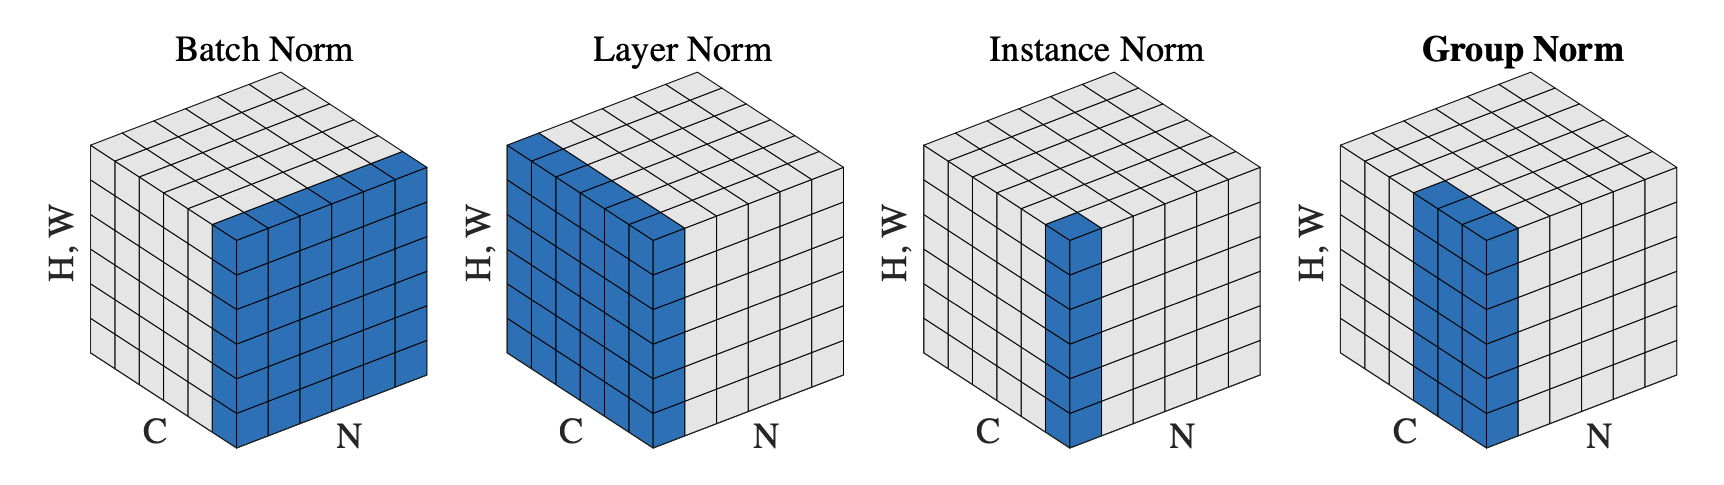

### Transfer Learning

> In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest. The three major Transfer Learning scenarios look as follows:

> **ConvNet as fixed feature extractor.** Take a ConvNet pretrained on ImageNet, remove the last fully-connected layer (this layer’s outputs are the 1000 class scores for a different task like ImageNet), then treat the rest of the ConvNet as a fixed feature extractor for the new dataset.

> **Fine-tuning the ConvNet.** The second strategy is to not only replace and retrain the classifier on top of the ConvNet on the new dataset, but to also fine-tune the weights of the pretrained network by continuing the backpropagation. It is possible to fine-tune all the layers of the ConvNet, or it’s possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network. 

> **Pretrained models.** Since modern ConvNets take 2-3 weeks to train across multiple GPUs on ImageNet, it is common to see people release their final ConvNet checkpoints for the benefit of others who can use the networks for fine-tuning.

source: https://cs231n.github.io/transfer-learning/

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

pretrained_model = torchvision.models.resnet18(weights=ResNet50_Weights)

for param in pretrained_model.parameters():
    param.requires_grad = False

num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 10)  # if doing CIFAR-10 for example

pretrained_model = pretrained_model.to(device)